In [1]:
import numpy as np
import pandas as pd


from scipy.stats import norm
from scipy.io import loadmat

from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.stats import norm
import multiprocessing as mp
from scipy.fft import fft, ifft, fftshift,ifftshift
from scipy.signal import fftconvolve
from scipy.optimize import curve_fit


In [2]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
def exp(x,w):
    
    return np.exp((-x**2)/(2*w**2))

# Gets width of AP in time by fitting exponential

In [9]:
ap = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/APShape20.xlsx') # Rat
ap2 = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/APShapePoint8.xlsx') # Sundt

In [34]:
def FitAPShape(ap): # Interpolates AP shape for a given AP
    

    tv = ap.iloc[:,0]
    v = ap.iloc[:,1]
    
    ### Sets peak time to 0
    peak = tv[np.argmax(v)]
    tv -= peak


    apShapeEmpirical = v.values
    
    apShapeEmpirical -= apShapeEmpirical[0] # Set baseline voltage to zero
    
    apShapeEmpirical /= np.max(apShapeEmpirical) # Set amplitude of AP to 1

         
    return apShapeEmpirical[50:], tv[50:] # Ignore initial transient

<IPython.core.display.Javascript object>


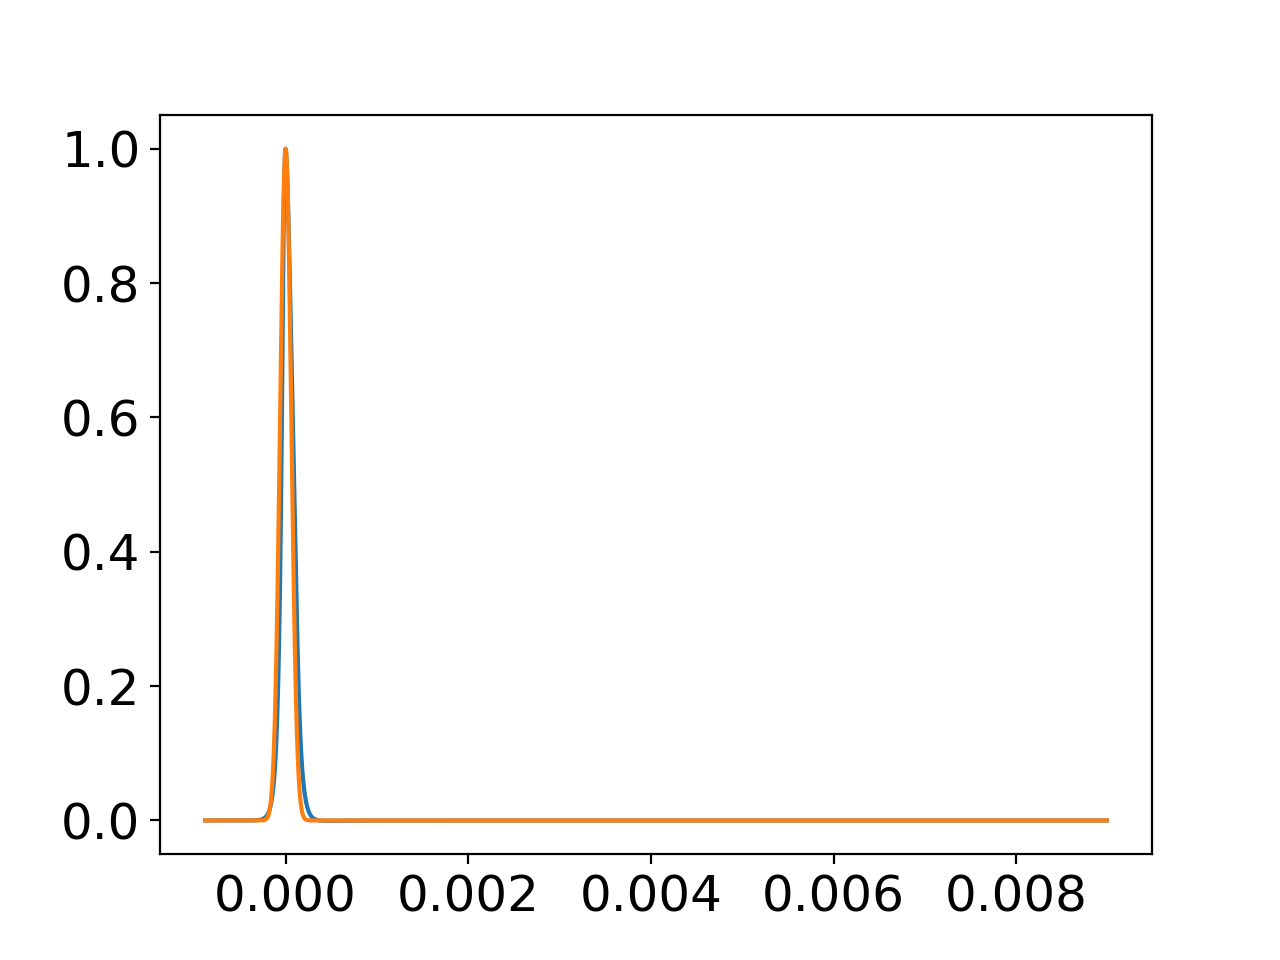

[6.0888754e-05]


In [42]:
apv, apt = FitAPShape(ap)
apw,_ = curve_fit(exp,apt,apv,p0=7e-5)
plt.figure()
plt.plot(apt,apv)
plt.plot(apt,exp(apt,apw))
print(apw) # Units s

<IPython.core.display.Javascript object>


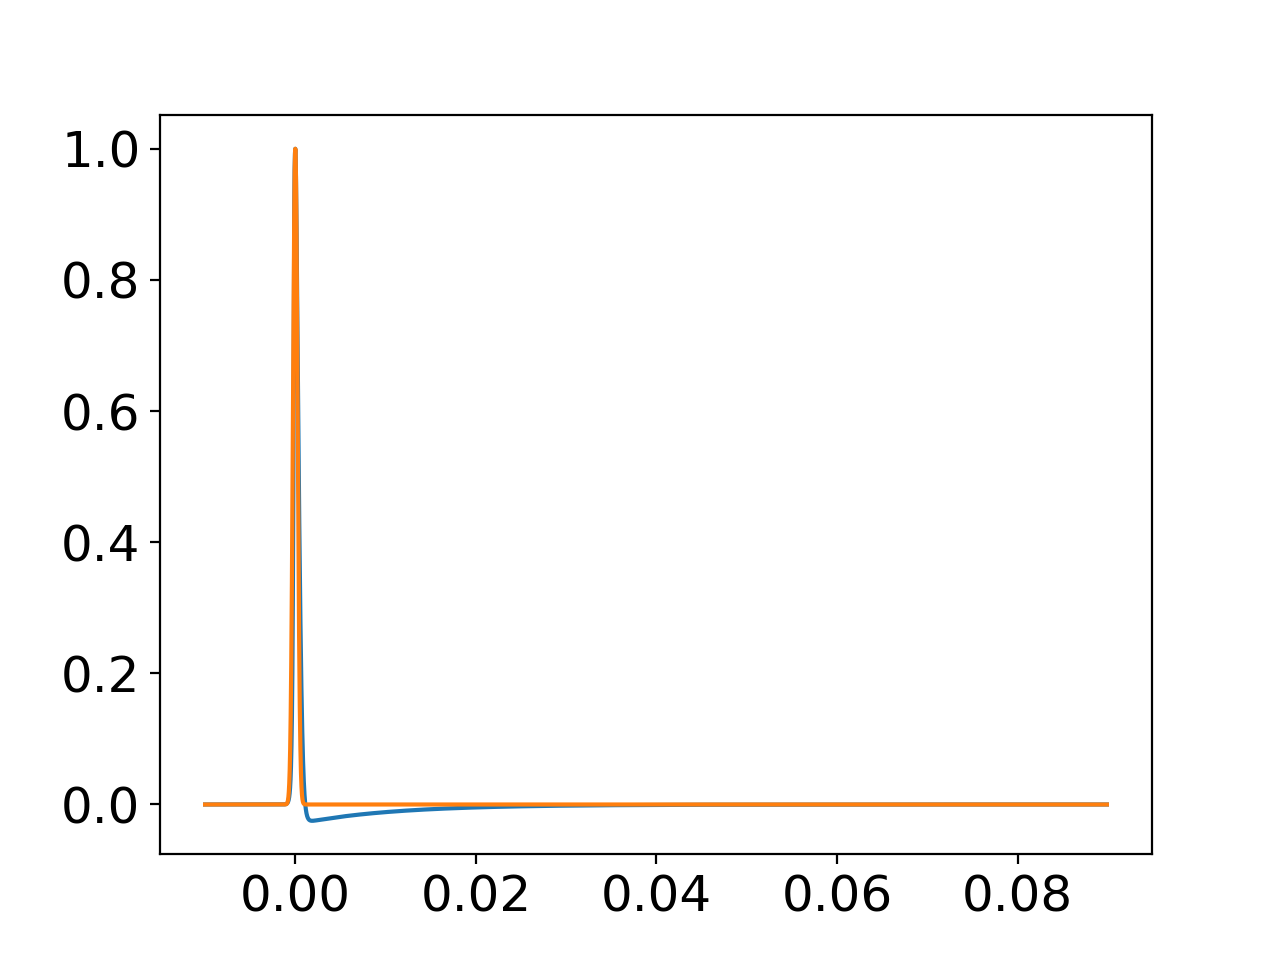

[0.00025523]


In [43]:
apv, apt = FitAPShape(ap2)
apw,_ = curve_fit(exp,apt,apv,p0=2e-4)
plt.figure()
plt.plot(apt,apv)
plt.plot(apt,exp(apt,apw))
print(apw) # Units s

In [50]:
def editPhiShape(phi,distance):
    
    ''' 
    This function takes the recording exposure curve from S4L, shifts it to match the desired distance from stimulus to recording, and smooths it
    '''
    
    xvals = phi.iloc[:,0].values+distance-phi.iloc[np.argmax(phi.iloc[:,1].values),0] # Shift to match desired distance

    phiShapeEmpirical = phi.iloc[:,1].values-np.mean(phi.iloc[:,1])

    
   ######## 
    
    ####### Makes sure that the potential at the proximal end of the fiber goes all the way to zero

    if np.any(phiShapeEmpirical[:np.argmax(phiShapeEmpirical)]<0): # If the potential is negative at the end of the fiber, sets the potential to 0
        
        
        first = np.where(phiShapeEmpirical[:np.argmax(phiShapeEmpirical)]<0)[0][-1]    
        
        phiShapeEmpirical[:first] = 0
        
    else: # If the potential does not go all the way to 0 by the end of the fiber, forces it to zero
        
        first = np.where(np.abs(np.diff(phiShapeEmpirical))>1e-4)[0][0] # Based on derivative of function, selects point after whcih not to change values
        

        ### Linearizes potential before this point, up until it reaches 0 
        firsta = np.where(phiShapeEmpirical[first]-1e-4*np.arange(first)<0)[0][0]
        firsta = first-firsta

        phiShapeEmpirical[firsta:first] = 1e-4*np.arange(first-firsta)
        #######
        
        phiShapeEmpirical[0:firsta]=0 # Sets potential to zero
        
    ############
   
    #### Does the same kind of smoothing as above, but for the distal end fo the fiber
    if np.any(phiShapeEmpirical[np.argmin(phiShapeEmpirical):]>0):
                
        last = np.where(phiShapeEmpirical[np.argmin(phiShapeEmpirical):]>0)[0][0]+np.argmin(phiShapeEmpirical)
        
        phiShapeEmpirical[last:] = 0
        
    else:
        last = np.where(np.abs(np.diff(phiShapeEmpirical))>1e-4)[0][-1]
        lasta = np.where(phiShapeEmpirical[last]+1e-4*np.arange(len(phiShapeEmpirical)-last)>0)[0][0]
        lasta += last

        phiShapeEmpirical[last:lasta] = 1e-4* np.arange(lasta-last)+ phiShapeEmpirical[last]
        phiShapeEmpirical[lasta:] = 0
        
        phiShapeEmpirical[phiShapeEmpirical<0] = 0 # Removes negative values to fit only one half
        
        phiShapeEmpirical /= np.max(phiShapeEmpirical) # Scales exposure function to 1
    

    return xvals, phiShapeEmpirical

<IPython.core.display.Javascript object>


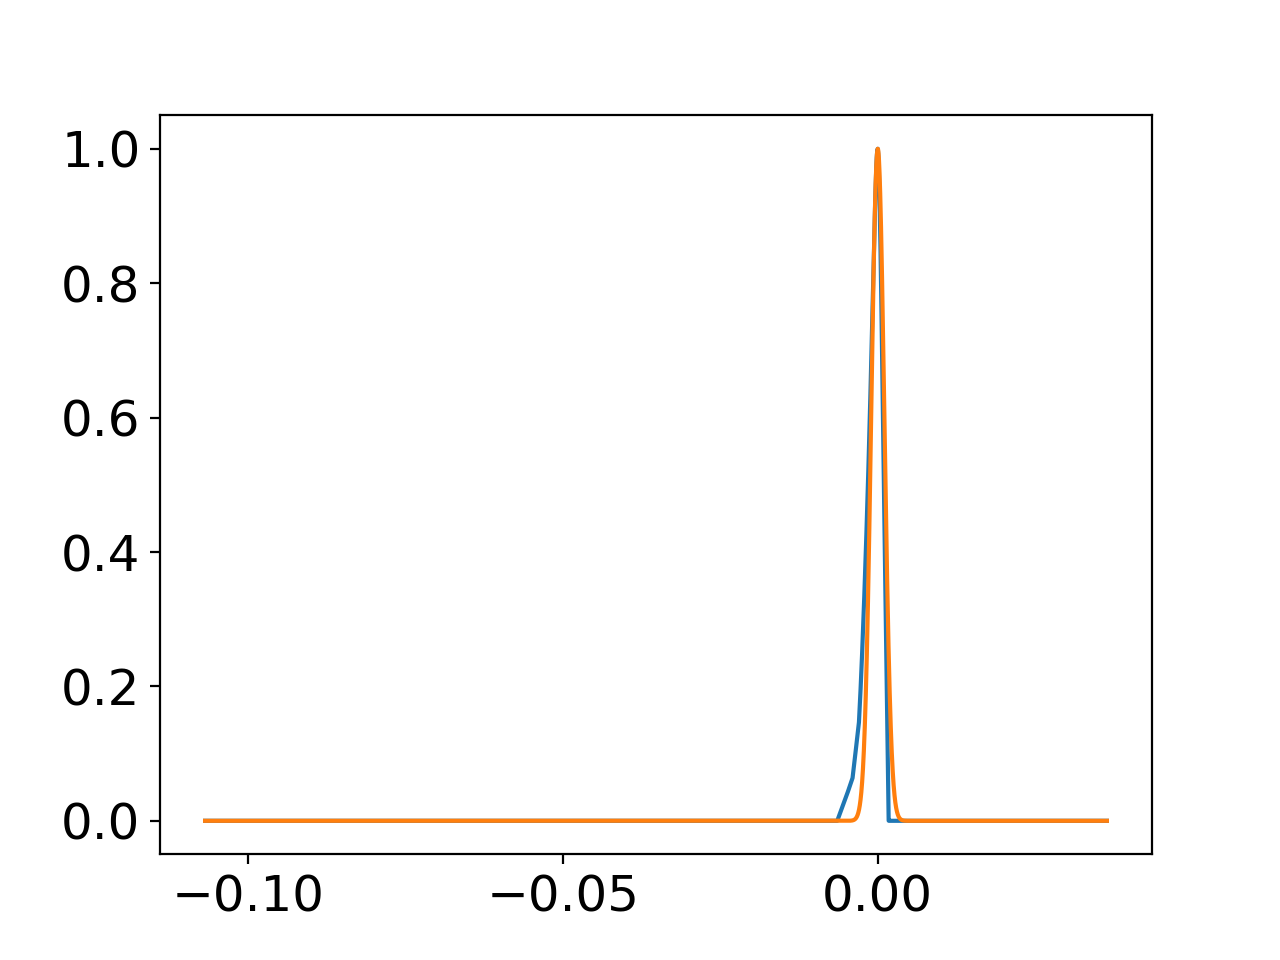

[0.00103997]


In [53]:
fascIdx = 0

phi = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_LowPerineurium/'+str(fascIdx)+'_BetterConductivity.xlsx')

xvals, phiShape = editPhiShape(phi,0)
phiw,_ = curve_fit(exp,xvals,phiShape,p0=1e-3)
plt.figure()
plt.plot(xvals,phiShape)
plt.plot(xvals,exp(xvals,phiw))
print(phiw) # Units m

In [58]:
phiwList = []

for fascIdx in range(39):
    
    phi = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_LowPerineurium/'+str(fascIdx)+'_BetterConductivity.xlsx')
    
    xvals, phiShape = editPhiShape(phi,0)
    phiw,_ = curve_fit(exp,xvals,phiShape,p0=1e-3)

    phiwList.append(phiw) # Units m
    
print(np.mean(phiwList))

0.0009548160287875903


In [59]:
print(np.std(phiwList))

9.887995301996126e-05


# Calculates velocity scaling parameters

In [55]:
d0Myelin = 20*1e-6
v0Myelin = 86.95
scaleMyelin = v0Myelin /d0Myelin
print(scaleMyelin) # Units 1/s

4347500.000000001


In [56]:
d0UMyelin = 0.8*1e-6
v0UMyelin = 0.416
scaleUMyelin = v0UMyelin /np.sqrt(d0UMyelin)
print(scaleUMyelin) # Units m^.5/s

465.1021393199562
